In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image = cv2.imread("test_image.jpg")
lane_image = np.copy(image)

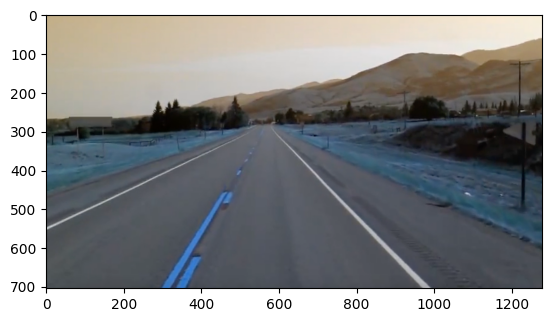

In [3]:
plt.imshow(image)
plt.show()

Convert The Image to Grayscale

In [4]:
gray = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)

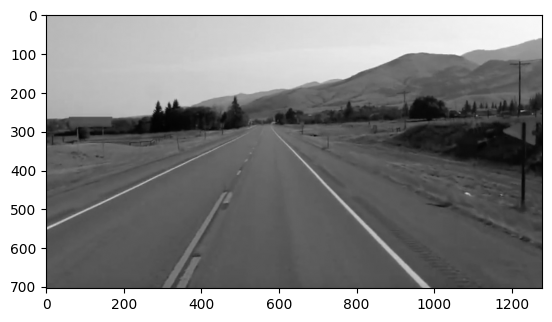

In [5]:
plt.imshow(gray, cmap='gray')
plt.show()

Add Gaussian Fillter to Smoothen the Image (Included in Canny Method)

In [6]:
blur = cv2.GaussianBlur(gray, (5, 5), 0)   

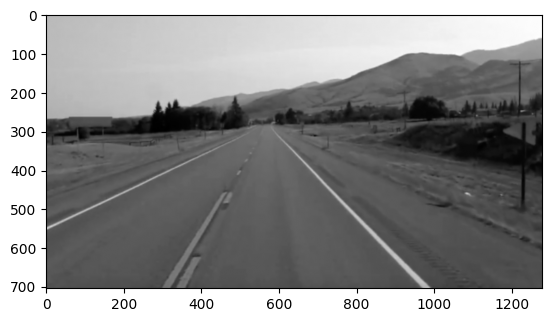

In [7]:
plt.imshow(blur, cmap='gray')
plt.show()

Using the Canny Function for generating the Gradient Image

In [8]:
canny = cv2.Canny(blur, 50, 150)

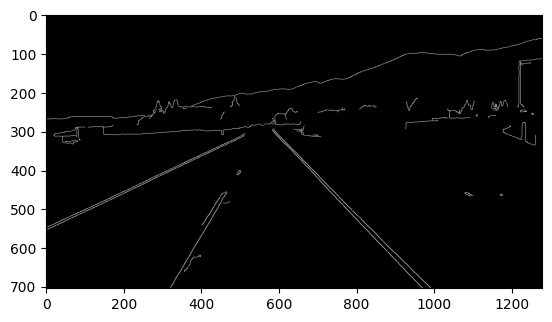

In [9]:
plt.imshow(canny, cmap='gray')
plt.show()

Creating a Canny Function

In [10]:
def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)   
    canny = cv2.Canny(blur, 50, 150)
    return canny    

In [11]:
canny_image = canny(lane_image)

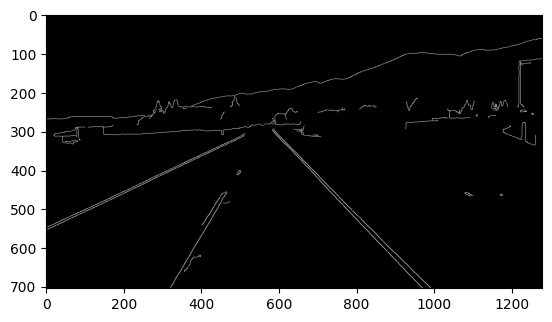

In [12]:
plt.imshow(canny_image, cmap='gray')
plt.show()

Creating a Function to generate a region of Interest

In [13]:
def region_of_interest(image):
    height = image.shape[0]
    polygons = np.array([
        [(200, height), (1100, height), (550, 250)]
        ])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    return mask


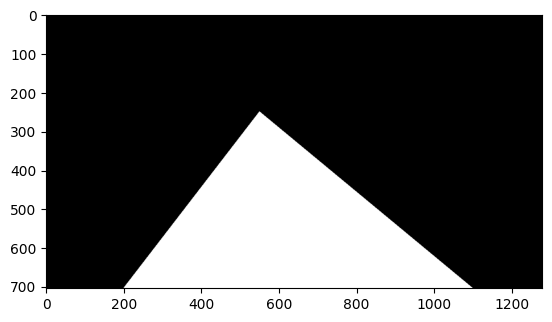

In [14]:
plt.imshow(region_of_interest(canny_image), cmap='gray')
plt.show()

Creating masked image from Region of Interest and Canny Image

In [15]:
def mask(image):
    height = image.shape[0]
    polygons = np.array([
        [(200, height), (1100, height), (550, 250)]
        ])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image


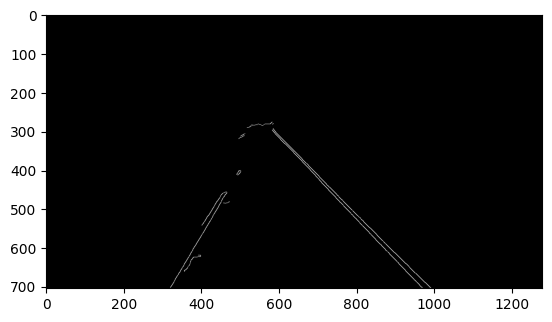

In [16]:
plt.imshow(mask(canny_image), cmap='gray')
plt.show()

Creating Lines Using Hough Space on the original image

In [17]:
#Optimizing Lines
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    # print(image.shape)
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1, y1, x2, y2])

In [18]:
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines: #segregating each line segment if it is part of a left lane or right lane
        x1, y1, x2, y2 = line.reshape(4) #x1,y1 coordinates of starting point of a line x2,y4 coordintes od endpooint of a line segment
        parameters = np.polyfit((x1, x2), (y1,y2), 1) #Finds m and b using given x and y for each lines by fitting it in the equation y=mx+b
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope,intercept))
        else :
            right_fit.append((slope, intercept))
    if len(left_fit) and len(right_fit):
        left_fit_average  = np.average(left_fit, axis=0)
        right_fit_average  = np.average(right_fit, axis=0)
        left_line = make_coordinates(image, left_fit_average)
        right_line = make_coordinates(image, right_fit_average)
        return np.array([left_line, right_line])

In [19]:
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

In [20]:
cropped_image = mask(canny_image)
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
averaged_lines = average_slope_intercept(lane_image, lines) #Optimizing the lines to smoother lines
line_image = display_lines(lane_image, averaged_lines)
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)

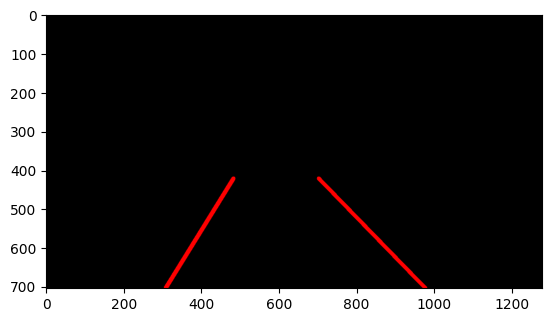

In [21]:
plt.imshow(line_image)
plt.show()

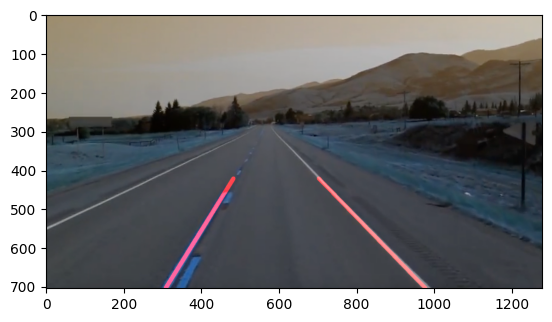

In [22]:
plt.imshow(combo_image)
plt.show()

In [23]:
# cv2.imshow('result',combo_image)
# cv2.waitKey(0)

Finding Lanes on Video

In [24]:
cap = cv2.VideoCapture("test2.mp4")
while(cap.isOpened()):
    _, frame = cap.read()
    canny_image = canny(frame)
    cropped_image = mask(canny_image)
    lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
    averaged_lines = average_slope_intercept(frame, lines) #Optimizing the lines to smoother lines
    line_image = display_lines(frame, averaged_lines)
    combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    cv2.imshow('result',combo_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release() 
cv2.destroyAllWindows()   